### Combining Everything from `workbook.ipynb`

In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import os

In [54]:
def fit_function(x, *params, E_c=100):
    """
    This function defines the mathmatecal function we want to fit the data to. In our case this is E = E_c * (I/I_c)^n.
    Parameters are I_c and n. E_c is set to the critical electric field criterion. 
    """
    I_c, n = params 
    return E_c * (x/I_c)**n

def power_fitting(xdata, ydata):
    """
    Fits the function defined in fit_function().

    arguments:
    ----------
    - xdata 
    - ydata
    - E_c - Electric Field Criterion for Critical Current

    returns:
    --------
    - I_c - critical current
    - n - exponent of (I/I_c)^n
    - popt - all parameters from scipy.optimize.curve_fit
    """

    # Initial Guesses
    guess = [1, 1]

    try:
        popt, pcov = curve_fit(fit_function, xdata, ydata, p0=guess, ) # can add maxfev=5000
    except RuntimeError as e:
        print('Fit did not converge:', e)
        return np.nan, np.nan, [np.nan, np.nan]

    I_c = popt[0]
    n = popt[1]

    return I_c, n, popt

# Iterate through files in specified directory #
def Analyse_Directory_PowerLawFit(directory):
    
    # Building a dataframe (table), each row is the analysis of one file in the directory
    rows = []
    for filename in os.listdir(directory):
        try:
            file_string = os.path.join(directory, filename).replace('\\','/')   # example string: 'data/P1_B1_Idefault_Ndefault.mat'
            # print(file_string)
            df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')
        except:
            print(f"Error: Cannot load {file_string}.")
            continue

        # Extract metadata from filename
        filename_split = file_string.split("_")
        angle = float(filename_split[-2])
        field = float(filename_split[-4])

        df['Efield_uVm-1'] = df['voltage_uV']/(1.4e-2) # Creating a new column for Electric field

        # Linear Fitting to half the data
        half = round(len(df)*0.5) # Finds the row index halfway through the data (usually around I = 18A)
        slope, intercept = linregress(df[:half]['current_A'], df[:half]['Efield_uVm-1'])[0:2] 
        linear_yvalues = df['current_A']*slope + intercept # The y-values of the linear fit extrapolated to the whole range of data that we will subtract from our data. 
        
        # Power Law Fitting to Cleaned Data (linear fit subtracted)
        xdata = df['current_A']
        ydata_clean = df['Efield_uVm-1'] - linear_yvalues
        I_c, n, popt = power_fitting(xdata, ydata_clean)
        if I_c is np.nan:
            print(f'No fit convergence for: {filename}')
        # Append the analysis of this file to the dataset
        row = [angle, field, I_c, n]
        rows.append(row)

    columns=['angle', 'field', 'I_c', 'n']
    df_directory = pd.DataFrame(rows, columns=columns)
    return df_directory

In [55]:
df_Ic_0 = Analyse_Directory_PowerLawFit('data/theta0/')
df_Ic_45 = Analyse_Directory_PowerLawFit('data/theta45/')
df_Ic_90 = Analyse_Directory_PowerLawFit('data/theta90/')
df_Ic_135 = Analyse_Directory_PowerLawFit('data/theta135/')
df_Ic_180 = Analyse_Directory_PowerLawFit('data/theta180/')
    
df_all = pd.concat([df_Ic_0, df_Ic_45, df_Ic_90, df_Ic_135, df_Ic_180], ignore_index=True)
df_all


Fit did not converge: Optimal parameters not found: Number of calls to function has reached maxfev = 600.
No fit convergence for: Measurement_5_0.50_Field_180_Angle.csv


,angle,field,I_c,n
0,0.0,0.00,72.932149,20.170951
1,0.0,0.02,68.695800,18.713237
2,0.0,0.04,58.247355,15.392334
3,0.0,0.05,54.299796,14.356633
4,0.0,0.08,46.453729,13.272716
5,0.0,0.10,43.042994,12.894923
6,0.0,0.20,33.230870,11.061152
7,0.0,0.30,29.240859,10.691260
8,0.0,0.40,26.845132,10.533195
9,0.0,0.50,26.034508,9.968940


**Applied Magnetic Field Dependence**

Text(0.5, 1.0, 'Magnetic Field Dependence on Critical Current')

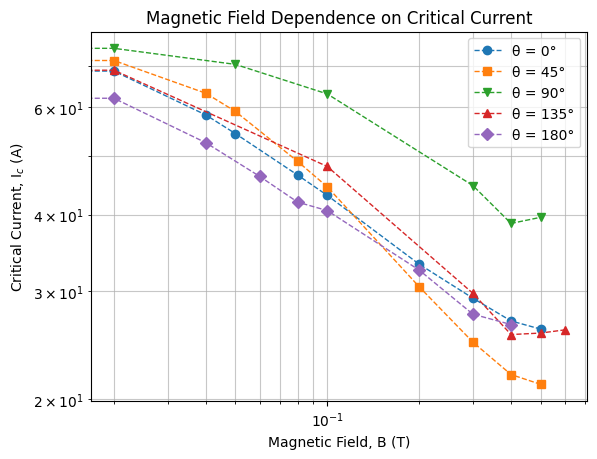

In [56]:
angles = df_all['angle'].unique()
markers = ['o','s','v','^','D','X']

fig, ax = plt.subplots()

for i, theta in enumerate(angles):
    df_filtered = df_all[df_all['angle']==theta]
    ax.errorbar(df_filtered['field'], df_filtered['I_c'], marker=markers[i], ls='--', lw=1, label=f'θ = {theta:.0f}°')

ax.set_xlabel('Magnetic Field, B (T)')
ax.set_xscale('log')

ax.set_ylabel('Critical Current, I$_c$ (A)')
ax.set_yscale('log')

ax.grid(visible=True, which='both', axis='both', alpha=0.7)
ax.legend()
ax.set_title('Magnetic Field Dependence on Critical Current')

**Angular Dependence (w.r.t. applied field)**

Text(0.5, 1.0, 'Angular Dependence on Critical Current')

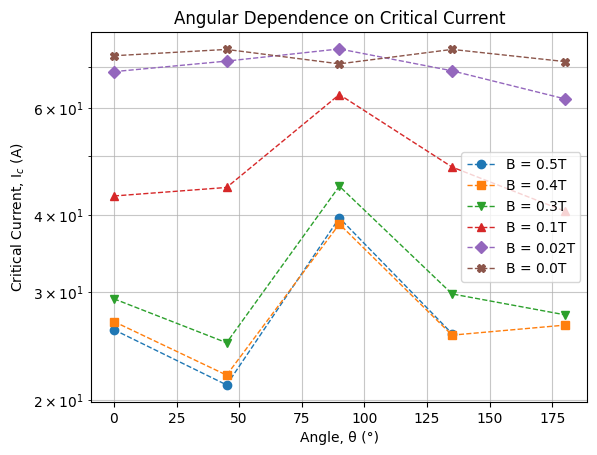

In [57]:
fields = [0.5, 0.4, 0.3, 0.1, 0.02, 0.00]
markers = ['o','s','v','^','D','X']

fig, ax = plt.subplots()

for i, B in enumerate(fields):
    df_filtered = df_all[df_all['field'] == B]
    ax.errorbar(df_filtered['angle'], df_filtered['I_c'], marker=markers[i], ls='--', lw=1, label=f'B = {B}T')

ax.set_xlabel('Angle, θ (°)')
ax.set_ylabel('Critical Current, I$_c$ (A)')
ax.set_yscale('log')

ax.grid(visible=True, which='both', axis='both', alpha=0.7)

ax.legend()
ax.set_title('Angular Dependence on Critical Current')